In [42]:
import cv2
import numpy as np
import os

def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        path = os.path.join(folder, label)
        if os.path.isdir(path):
            for filename in os.listdir(path):
                img_path = os.path.join(path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img_resized = cv2.resize(img, (128, 128))
                    images.append(img_resized)
                    labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder('/kaggle/input/cars-image-dataset/Cars Dataset/train')
test_images, test_labels = load_images_from_folder('/kaggle/input/cars-image-dataset/Cars Dataset/test')


In [44]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")


Num GPUs Available:  1
GPU is available


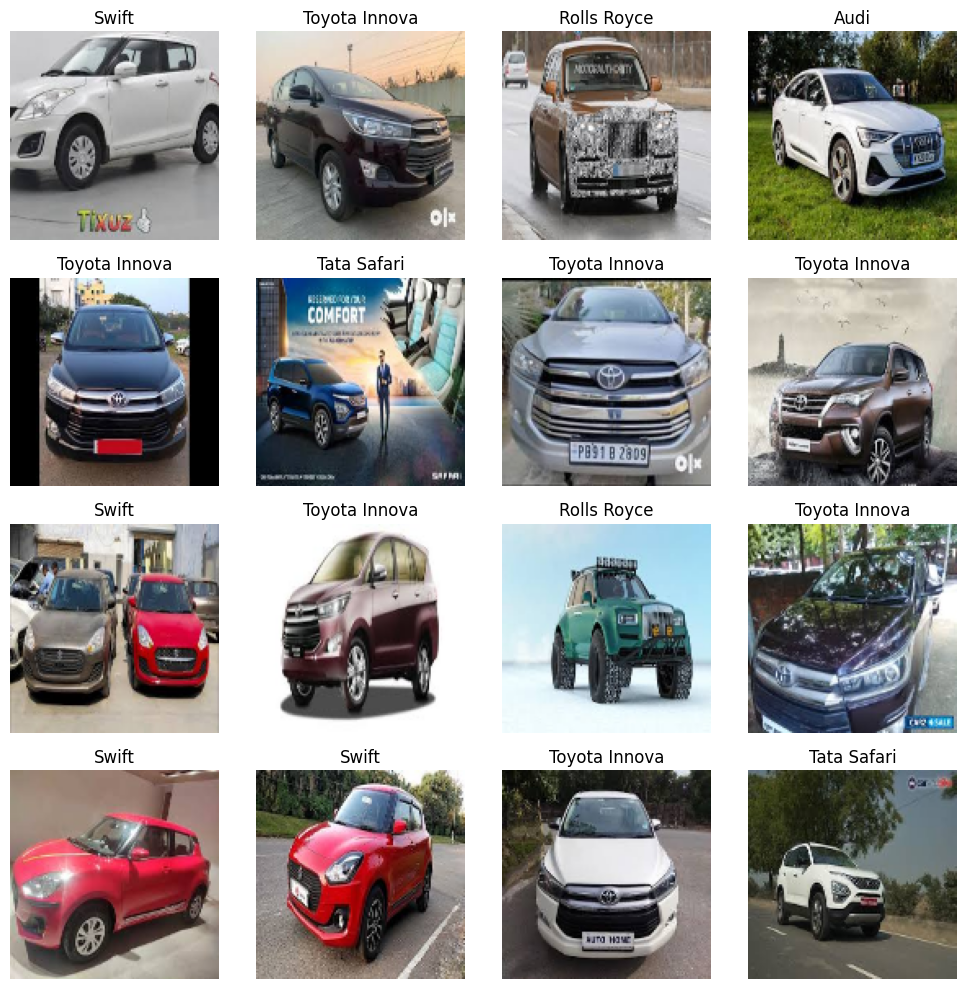

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_images(images, labels, nrows=4, ncols=4):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    axes = axes.flatten()
    
    indices = np.random.choice(len(images), nrows * ncols, replace=False)
    
    for idx, ax in zip(indices, axes):
        img = images[idx]
        if img.dtype != np.uint8: 
            img = (img * 255).astype('uint8')

        if img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.set_title(labels[idx])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_images(train_images, train_labels, nrows=4, ncols=4)


In [46]:
train_images = train_images / 255.0
test_images = test_images / 255.0

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_one_hot = to_categorical(train_labels_encoded)
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_one_hot = to_categorical(test_labels_encoded)

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam, Adamax

def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Flatten(),

        Dense(1024, activation='relu', kernel_regularizer=l1(0.0001)),
        Dropout(0.5),
        
        Dense(32, activation='relu', kernel_regularizer=l1(0.0001)),
        
        Dense(units=7, activation='softmax')
    ])
    
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [48]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical

def calculate_metrics(y_test, y_score, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    precision = dict()
    recall = dict()
    pr_auc = dict()

    y_test = label_binarize(y_test, classes=np.arange(num_classes))

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    return fpr, tpr, roc_auc, precision, recall, pr_auc

In [49]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}: accuracy = {logs['accuracy']:.4f}, loss = {logs['loss']:.4f}, val_accuracy = {logs['val_accuracy']:.4f}, val_loss = {logs['val_loss']:.4f}")


In [61]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

X = train_images
y = np.argmax(train_labels_one_hot, axis=1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
num_classes = 7
accumulated_cm = np.zeros((7, 7), dtype=int)
val_loss_history = []  
train_loss_history = []

val_accuracy_history = [] 
train_accuracy_history = []

all_fpr = []
all_tpr = []
all_precision = []
all_recall = []

metrics_results = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'auc': []
}


fold_no = 1
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index] 
    
    y_train_fold_onehot = to_categorical(y_train_fold, num_classes=np.max(y)+1)
    y_test_fold_onehot = to_categorical(y_test_fold, num_classes=np.max(y)+1)


    model = build_model()

    print(f'Training for fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold_onehot, epochs=70, validation_data=(X_test_fold, y_test_fold_onehot), callbacks=[CustomCallback()], verbose=0)
    
    y_pred_prob = model.predict(X_test_fold)
    y_pred = np.argmax(y_pred_prob, axis=1)

    val_loss_history.append(history.history['val_loss'])
    train_loss_history.append(history.history['loss'])
    val_accuracy_history.append(history.history['val_accuracy'])
    train_accuracy_history.append(history.history['accuracy'])  
    
    y_pred_prob = model.predict(X_test_fold)
    y_pred = np.argmax(y_pred_prob, axis=1)

    fpr, tpr, roc_auc, precision, recall, pr_auc = calculate_metrics(y_test_fold, y_pred_prob, num_classes)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_precision.append(precision)
    all_recall.append(recall)
    
    metrics_results['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics_results['recall'].append(recall_score(y_test_fold, y_pred, average='macro'))
    metrics_results['precision'].append(precision_score(y_test_fold, y_pred, average='macro'))
    metrics_results['f1'].append(f1_score(y_test_fold, y_pred, average='macro'))
    metrics_results['auc'].append(roc_auc_score(y_test_fold_onehot, y_pred_prob, multi_class='ovr'))

    
    cm = confusion_matrix(y_test_fold, y_pred)
    accumulated_cm += cm

    fold_no += 1

Training for fold 1...


W0000 00:00:1714279311.046757     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714279320.976971     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 5: accuracy = 0.3644, loss = 6.2889, val_accuracy = 0.3720, val_loss = 6.1467
Epoch 10: accuracy = 0.4851, loss = 4.6204, val_accuracy = 0.4911, val_loss = 4.5425
Epoch 15: accuracy = 0.6426, loss = 3.4298, val_accuracy = 0.5774, val_loss = 3.4895
Epoch 20: accuracy = 0.7566, loss = 2.6856, val_accuracy = 0.6399, val_loss = 2.9477
Epoch 25: accuracy = 0.8468, loss = 2.2057, val_accuracy = 0.6994, val_loss = 2.6172
Epoch 30: accuracy = 0.8946, loss = 1.8913, val_accuracy = 0.7083, val_loss = 2.3701
Epoch 35: accuracy = 0.9397, loss = 1.6321, val_accuracy = 0.6994, val_loss = 2.3124
Epoch 40: accuracy = 0.9377, loss = 1.4880, val_accuracy = 0.7054, val_loss = 2.1968
Epoch 45: accuracy = 0.9586, loss = 1.3319, val_accuracy = 0.7232, val_loss = 2.0406
Epoch 50: accuracy = 0.9675, loss = 1.2124, val_accuracy = 0.7440, val_loss = 1.8423
Epoch 55: accuracy = 0.9682, loss = 1.1525, val_accuracy = 0.7470, val_loss = 1.8220
Epoch 60: accuracy = 0.9715, loss = 1.0630, val_accuracy = 0.7351,

W0000 00:00:1714279400.897488     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training for fold 2...


W0000 00:00:1714279413.792450     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714279423.324913     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 5: accuracy = 0.3435, loss = 6.1452, val_accuracy = 0.3631, val_loss = 6.1383
Epoch 10: accuracy = 0.5109, loss = 4.4722, val_accuracy = 0.4613, val_loss = 4.5644
Epoch 15: accuracy = 0.6694, loss = 3.3161, val_accuracy = 0.5327, val_loss = 3.7238
Epoch 20: accuracy = 0.7619, loss = 2.6393, val_accuracy = 0.6280, val_loss = 3.1864
Epoch 25: accuracy = 0.8574, loss = 2.1752, val_accuracy = 0.6488, val_loss = 2.8368
Epoch 30: accuracy = 0.9075, loss = 1.8445, val_accuracy = 0.6905, val_loss = 2.6380
Epoch 35: accuracy = 0.9420, loss = 1.5977, val_accuracy = 0.6875, val_loss = 2.5924
Epoch 40: accuracy = 0.9582, loss = 1.4310, val_accuracy = 0.7024, val_loss = 2.3183
Epoch 45: accuracy = 0.9755, loss = 1.2770, val_accuracy = 0.7083, val_loss = 2.2713
Epoch 50: accuracy = 0.9645, loss = 1.1866, val_accuracy = 0.7232, val_loss = 2.1766
Epoch 55: accuracy = 0.9688, loss = 1.1286, val_accuracy = 0.7083, val_loss = 2.0999
Epoch 60: accuracy = 0.9761, loss = 1.0491, val_accuracy = 0.7262,

W0000 00:00:1714279503.488650     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training for fold 3...


W0000 00:00:1714279516.671271     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714279525.985543     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 5: accuracy = 0.3013, loss = 5.9678, val_accuracy = 0.3015, val_loss = 5.9352
Epoch 10: accuracy = 0.4687, loss = 4.2086, val_accuracy = 0.4119, val_loss = 4.3889
Epoch 15: accuracy = 0.6238, loss = 3.1443, val_accuracy = 0.5373, val_loss = 3.3576
Epoch 20: accuracy = 0.7700, loss = 2.4643, val_accuracy = 0.6448, val_loss = 2.8392
Epoch 25: accuracy = 0.8601, loss = 2.0223, val_accuracy = 0.7015, val_loss = 2.5933
Epoch 30: accuracy = 0.9118, loss = 1.7375, val_accuracy = 0.6657, val_loss = 2.5513
Epoch 35: accuracy = 0.9496, loss = 1.5088, val_accuracy = 0.7045, val_loss = 2.3265
Epoch 40: accuracy = 0.9543, loss = 1.3500, val_accuracy = 0.7254, val_loss = 2.2198
Epoch 45: accuracy = 0.9649, loss = 1.2277, val_accuracy = 0.7045, val_loss = 2.1570
Epoch 50: accuracy = 0.9705, loss = 1.1401, val_accuracy = 0.7313, val_loss = 2.0381
Epoch 55: accuracy = 0.9698, loss = 1.0626, val_accuracy = 0.7343, val_loss = 2.0471
Epoch 60: accuracy = 0.9758, loss = 1.0137, val_accuracy = 0.7254,

W0000 00:00:1714279608.183341     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training for fold 4...


W0000 00:00:1714279621.875454     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714279631.718795     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 5: accuracy = 0.3666, loss = 6.3387, val_accuracy = 0.3403, val_loss = 6.2850
Epoch 10: accuracy = 0.5423, loss = 4.7158, val_accuracy = 0.5612, val_loss = 4.7607
Epoch 15: accuracy = 0.6924, loss = 3.6037, val_accuracy = 0.6687, val_loss = 3.7960
Epoch 20: accuracy = 0.8184, loss = 2.8582, val_accuracy = 0.6925, val_loss = 3.3233
Epoch 25: accuracy = 0.8790, loss = 2.3890, val_accuracy = 0.7075, val_loss = 3.0202
Epoch 30: accuracy = 0.9350, loss = 1.9929, val_accuracy = 0.7134, val_loss = 2.7876
Epoch 35: accuracy = 0.9470, loss = 1.7448, val_accuracy = 0.7045, val_loss = 2.5590
Epoch 40: accuracy = 0.9582, loss = 1.5489, val_accuracy = 0.7104, val_loss = 2.4835
Epoch 45: accuracy = 0.9659, loss = 1.3883, val_accuracy = 0.7075, val_loss = 2.2842
Epoch 50: accuracy = 0.9722, loss = 1.2542, val_accuracy = 0.7045, val_loss = 2.2394
Epoch 55: accuracy = 0.9688, loss = 1.1726, val_accuracy = 0.7075, val_loss = 2.1648
Epoch 60: accuracy = 0.9761, loss = 1.0774, val_accuracy = 0.6896,

W0000 00:00:1714279713.752878     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training for fold 5...


W0000 00:00:1714279726.910079     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714279736.444868     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 5: accuracy = 0.3295, loss = 6.6005, val_accuracy = 0.4090, val_loss = 6.4735
Epoch 10: accuracy = 0.5114, loss = 5.0389, val_accuracy = 0.5463, val_loss = 4.8640
Epoch 15: accuracy = 0.6768, loss = 3.8222, val_accuracy = 0.6507, val_loss = 3.8509
Epoch 20: accuracy = 0.7998, loss = 2.9879, val_accuracy = 0.7493, val_loss = 3.1897
Epoch 25: accuracy = 0.8863, loss = 2.4230, val_accuracy = 0.7731, val_loss = 2.8456
Epoch 30: accuracy = 0.9244, loss = 2.0504, val_accuracy = 0.7821, val_loss = 2.5692
Epoch 35: accuracy = 0.9576, loss = 1.7558, val_accuracy = 0.7612, val_loss = 2.4032
Epoch 40: accuracy = 0.9592, loss = 1.5591, val_accuracy = 0.7672, val_loss = 2.1825
Epoch 45: accuracy = 0.9622, loss = 1.4136, val_accuracy = 0.7851, val_loss = 2.0860
Epoch 50: accuracy = 0.9758, loss = 1.2621, val_accuracy = 0.8000, val_loss = 1.9950
Epoch 55: accuracy = 0.9732, loss = 1.1931, val_accuracy = 0.8090, val_loss = 1.8257
Epoch 60: accuracy = 0.9788, loss = 1.0989, val_accuracy = 0.7970,

W0000 00:00:1714279816.633419     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training for fold 6...


W0000 00:00:1714279829.846108     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714279839.156680     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 5: accuracy = 0.3146, loss = 6.4033, val_accuracy = 0.3612, val_loss = 6.1912
Epoch 10: accuracy = 0.5051, loss = 4.7338, val_accuracy = 0.5373, val_loss = 4.6356
Epoch 15: accuracy = 0.6573, loss = 3.5556, val_accuracy = 0.5791, val_loss = 3.8671
Epoch 20: accuracy = 0.7892, loss = 2.7693, val_accuracy = 0.6567, val_loss = 3.1669
Epoch 25: accuracy = 0.8714, loss = 2.2685, val_accuracy = 0.6896, val_loss = 2.8777
Epoch 30: accuracy = 0.9062, loss = 1.9370, val_accuracy = 0.7194, val_loss = 2.5758
Epoch 35: accuracy = 0.9460, loss = 1.6496, val_accuracy = 0.6985, val_loss = 2.4589
Epoch 40: accuracy = 0.9645, loss = 1.4425, val_accuracy = 0.7463, val_loss = 2.2226
Epoch 45: accuracy = 0.9692, loss = 1.3065, val_accuracy = 0.7164, val_loss = 2.0917
Epoch 50: accuracy = 0.9745, loss = 1.1932, val_accuracy = 0.7463, val_loss = 2.0269
Epoch 55: accuracy = 0.9708, loss = 1.1299, val_accuracy = 0.7284, val_loss = 1.9611
Epoch 60: accuracy = 0.9785, loss = 1.0461, val_accuracy = 0.7373,

W0000 00:00:1714279918.693415     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training for fold 7...


W0000 00:00:1714279931.521202     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714279940.950332     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 5: accuracy = 0.2771, loss = 6.5153, val_accuracy = 0.2925, val_loss = 6.3138
Epoch 10: accuracy = 0.3560, loss = 4.9340, val_accuracy = 0.3642, val_loss = 4.7867
Epoch 15: accuracy = 0.4935, loss = 3.7498, val_accuracy = 0.4746, val_loss = 3.7215
Epoch 20: accuracy = 0.6546, loss = 2.9145, val_accuracy = 0.5821, val_loss = 3.1793
Epoch 25: accuracy = 0.7802, loss = 2.3504, val_accuracy = 0.6806, val_loss = 2.7574
Epoch 30: accuracy = 0.8687, loss = 1.9832, val_accuracy = 0.7164, val_loss = 2.4812
Epoch 35: accuracy = 0.9185, loss = 1.6883, val_accuracy = 0.7313, val_loss = 2.3276
Epoch 40: accuracy = 0.9483, loss = 1.4766, val_accuracy = 0.7194, val_loss = 2.2130
Epoch 45: accuracy = 0.9609, loss = 1.3302, val_accuracy = 0.7134, val_loss = 2.1613
Epoch 50: accuracy = 0.9599, loss = 1.2381, val_accuracy = 0.7194, val_loss = 2.1662
Epoch 55: accuracy = 0.9652, loss = 1.1526, val_accuracy = 0.7343, val_loss = 2.0117
Epoch 60: accuracy = 0.9775, loss = 1.0633, val_accuracy = 0.7313,

W0000 00:00:1714280020.476732     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training for fold 8...


W0000 00:00:1714280033.084236     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714280042.111317     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 5: accuracy = 0.3364, loss = 6.2391, val_accuracy = 0.3403, val_loss = 6.2314
Epoch 10: accuracy = 0.5462, loss = 4.5885, val_accuracy = 0.5224, val_loss = 4.5847
Epoch 15: accuracy = 0.7073, loss = 3.5077, val_accuracy = 0.5910, val_loss = 3.9266
Epoch 20: accuracy = 0.8296, loss = 2.7897, val_accuracy = 0.6299, val_loss = 3.4044
Epoch 25: accuracy = 0.8880, loss = 2.3243, val_accuracy = 0.6746, val_loss = 3.0137
Epoch 30: accuracy = 0.9271, loss = 1.9691, val_accuracy = 0.6925, val_loss = 2.7727
Epoch 35: accuracy = 0.9450, loss = 1.7100, val_accuracy = 0.7104, val_loss = 2.5350
Epoch 40: accuracy = 0.9639, loss = 1.5024, val_accuracy = 0.7284, val_loss = 2.3324
Epoch 45: accuracy = 0.9645, loss = 1.3796, val_accuracy = 0.6985, val_loss = 2.2546
Epoch 50: accuracy = 0.9708, loss = 1.2425, val_accuracy = 0.7045, val_loss = 2.1321
Epoch 55: accuracy = 0.9728, loss = 1.1580, val_accuracy = 0.7134, val_loss = 2.1430
Epoch 60: accuracy = 0.9738, loss = 1.1112, val_accuracy = 0.7284,

W0000 00:00:1714280121.931262     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training for fold 9...


W0000 00:00:1714280134.701430     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714280143.898162     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 5: accuracy = 0.3732, loss = 6.2532, val_accuracy = 0.3403, val_loss = 6.3405
Epoch 10: accuracy = 0.5631, loss = 4.5889, val_accuracy = 0.5463, val_loss = 4.7450
Epoch 15: accuracy = 0.6974, loss = 3.4856, val_accuracy = 0.6418, val_loss = 3.7985
Epoch 20: accuracy = 0.8220, loss = 2.7589, val_accuracy = 0.6537, val_loss = 3.2952
Epoch 25: accuracy = 0.8820, loss = 2.2960, val_accuracy = 0.7104, val_loss = 3.0186
Epoch 30: accuracy = 0.9304, loss = 1.9403, val_accuracy = 0.7164, val_loss = 2.8053
Epoch 35: accuracy = 0.9466, loss = 1.6942, val_accuracy = 0.7313, val_loss = 2.6368
Epoch 40: accuracy = 0.9602, loss = 1.5016, val_accuracy = 0.7343, val_loss = 2.4494
Epoch 45: accuracy = 0.9692, loss = 1.3609, val_accuracy = 0.7254, val_loss = 2.4326
Epoch 50: accuracy = 0.9745, loss = 1.2543, val_accuracy = 0.7373, val_loss = 2.2774
Epoch 55: accuracy = 0.9695, loss = 1.1775, val_accuracy = 0.7224, val_loss = 2.2477
Epoch 60: accuracy = 0.9741, loss = 1.1099, val_accuracy = 0.7313,

W0000 00:00:1714280226.584486     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training for fold 10...


W0000 00:00:1714280240.396922     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714280250.362533     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 5: accuracy = 0.2927, loss = 6.3058, val_accuracy = 0.2507, val_loss = 6.1356
Epoch 10: accuracy = 0.4176, loss = 4.5669, val_accuracy = 0.3940, val_loss = 4.6017
Epoch 15: accuracy = 0.5598, loss = 3.3943, val_accuracy = 0.5254, val_loss = 3.4572
Epoch 20: accuracy = 0.7040, loss = 2.6574, val_accuracy = 0.6239, val_loss = 2.8769
Epoch 25: accuracy = 0.8157, loss = 2.1136, val_accuracy = 0.6627, val_loss = 2.5445
Epoch 30: accuracy = 0.8827, loss = 1.8189, val_accuracy = 0.6896, val_loss = 2.4204
Epoch 35: accuracy = 0.9244, loss = 1.5733, val_accuracy = 0.7045, val_loss = 2.2874
Epoch 40: accuracy = 0.9367, loss = 1.4186, val_accuracy = 0.7015, val_loss = 2.2399
Epoch 45: accuracy = 0.9629, loss = 1.2594, val_accuracy = 0.7015, val_loss = 2.1496
Epoch 50: accuracy = 0.9559, loss = 1.1977, val_accuracy = 0.7045, val_loss = 2.0843
Epoch 55: accuracy = 0.9695, loss = 1.0930, val_accuracy = 0.7194, val_loss = 2.0311
Epoch 60: accuracy = 0.9771, loss = 1.0121, val_accuracy = 0.7045,

W0000 00:00:1714280332.465302     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [62]:
print("Average Metrics Across All Folds:")
for metric, values in metrics_results.items():
    print(f"{metric}: {np.mean(values):.4f}")


Average Metrics Across All Folds:
accuracy: 0.7312
recall: 0.6890
precision: 0.7194
f1: 0.6977
auc: 0.9324


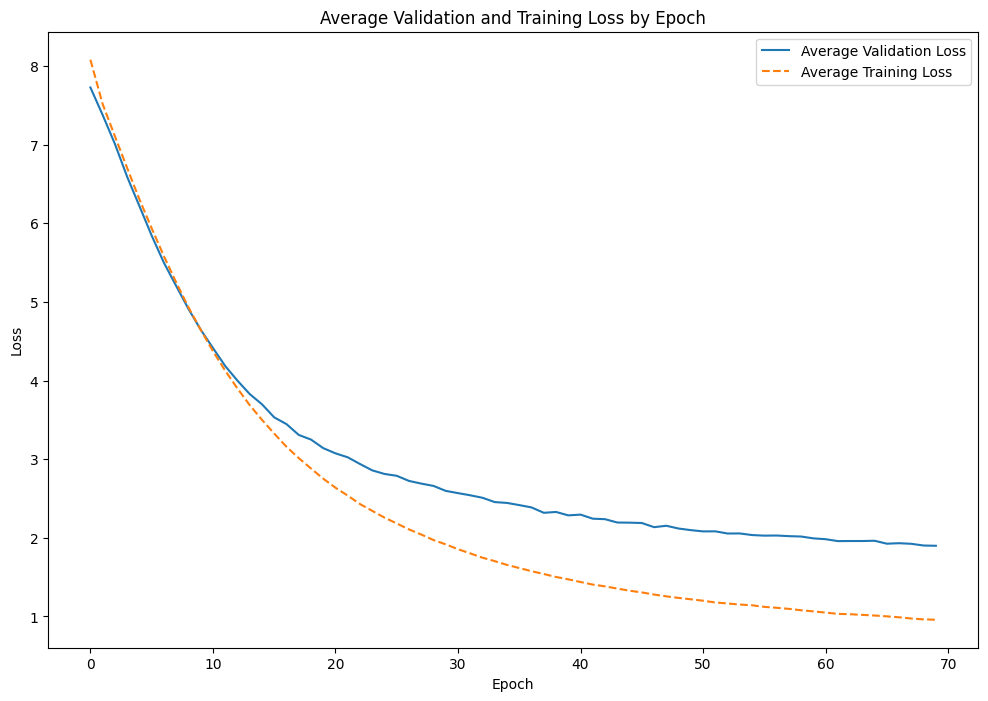

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(val_loss_history, train_loss_history):
    plt.figure(figsize=(12, 8))

    avg_val_loss = np.mean(val_loss_history, axis=0)
    avg_train_loss = np.mean(train_loss_history, axis=0)

    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.plot(avg_train_loss, label='Average Training Loss', linestyle='--')

    plt.title('Average Validation and Training Loss by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(val_loss_history, train_loss_history)


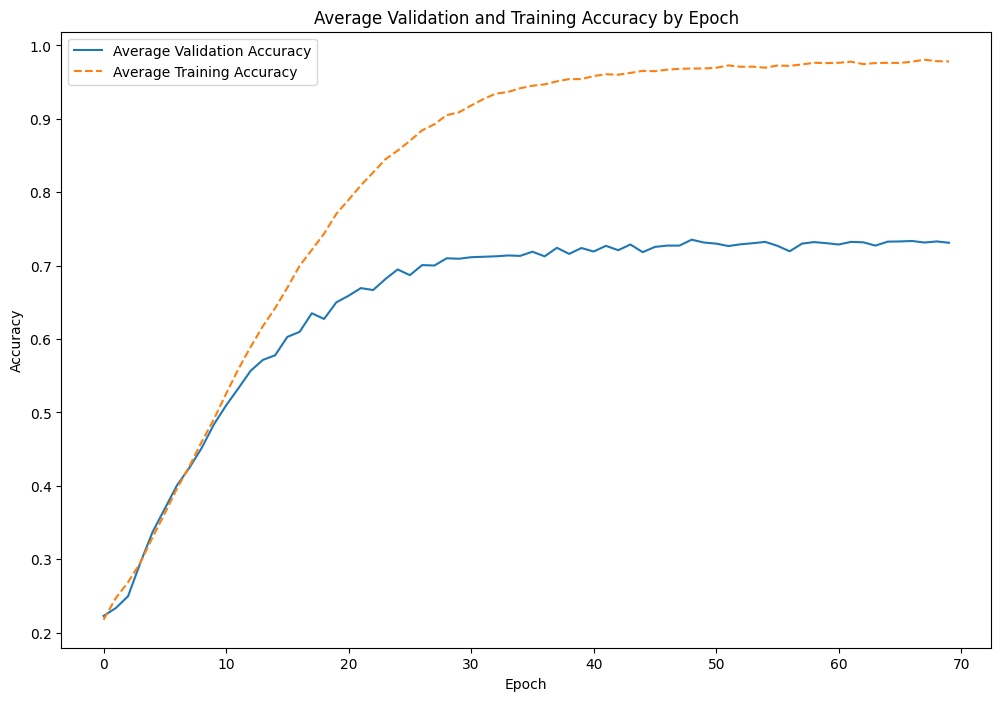

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy(val_accuracy_history, train_accuracy_history):
    plt.figure(figsize=(12, 8))

    avg_val_accuracy = np.mean(val_accuracy_history, axis=0)
    avg_train_accuracy = np.mean(train_accuracy_history, axis=0)

    plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
    plt.plot(avg_train_accuracy, label='Average Training Accuracy', linestyle='--')

    plt.title('Average Validation and Training Accuracy by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(val_accuracy_history, train_accuracy_history)


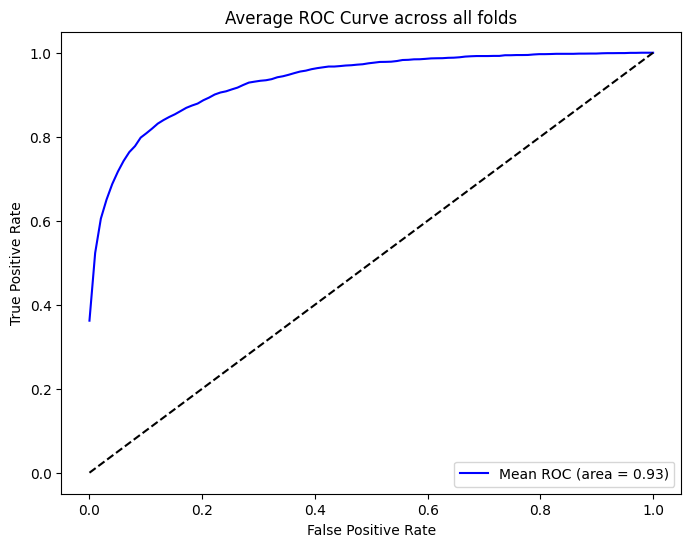

In [65]:
from scipy import interp
from numpy import linspace

def plot_average_roc(all_fpr, all_tpr, num_classes):
    mean_fpr = linspace(0, 1, 100)
    
    mean_tpr = np.zeros_like(mean_fpr)
    for fpr, tpr in zip(all_fpr, all_tpr):
        for i in range(num_classes):
            mean_tpr += interp(mean_fpr, fpr[i], tpr[i])
    
    mean_tpr /= (len(all_fpr) * num_classes)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=f'Mean ROC (area = {auc(mean_fpr, mean_tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across all folds')
    plt.legend(loc='lower right')
    plt.show()

plot_average_roc(all_fpr, all_tpr, num_classes)

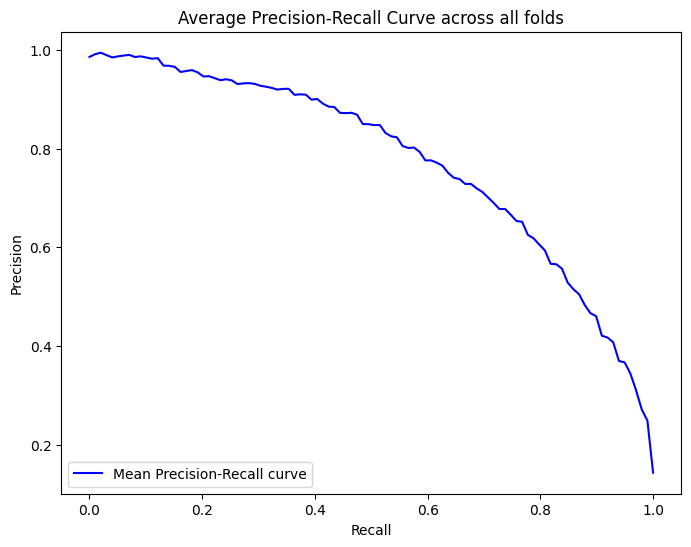

In [66]:
def plot_average_precision_recall(all_precision, all_recall, num_classes):
    mean_recall = linspace(0, 1, 100)
    
    mean_precision = np.zeros_like(mean_recall)
    for precision, recall in zip(all_precision, all_recall):
        for i in range(num_classes):
            mean_precision += interp(mean_recall, recall[i][::-1], precision[i][::-1])
    
    mean_precision /= (len(all_precision) * num_classes)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_recall, mean_precision, color='blue',
             label='Mean Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average Precision-Recall Curve across all folds')
    plt.legend(loc='lower left')
    plt.show()

plot_average_precision_recall(all_precision, all_recall, num_classes)


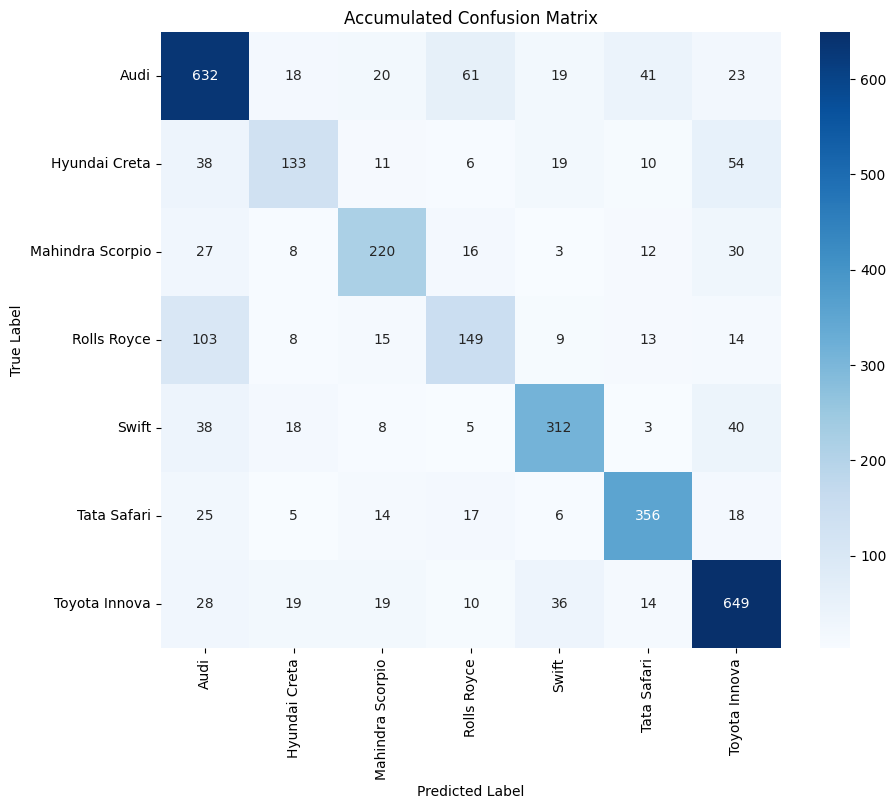

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Accumulated Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

class_names = ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
plot_confusion_matrix(accumulated_cm, class_names)


In [68]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


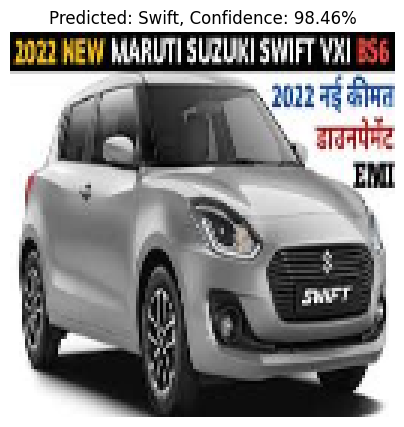

Predictions for each class:
Audi: 0.09%
Hyundai Creta: 0.01%
Mahindra Scorpio: 0.66%
Rolls Royce: 0.00%
Swift: 98.46%
Tata Safari: 0.00%
Toyota Innova: 0.78%




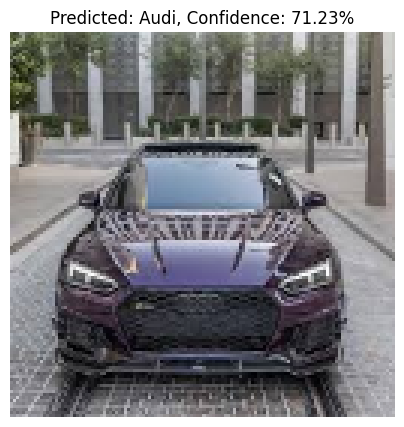

Predictions for each class:
Audi: 71.23%
Hyundai Creta: 0.18%
Mahindra Scorpio: 0.22%
Rolls Royce: 2.71%
Swift: 0.13%
Tata Safari: 25.49%
Toyota Innova: 0.04%




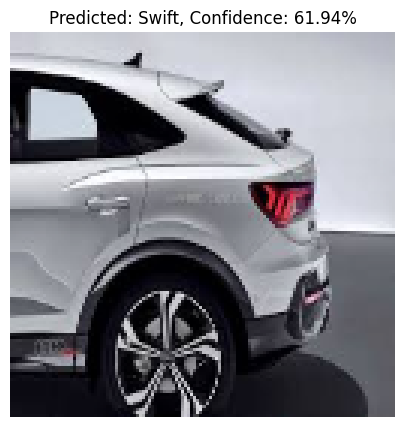

Predictions for each class:
Audi: 15.26%
Hyundai Creta: 12.06%
Mahindra Scorpio: 0.03%
Rolls Royce: 1.90%
Swift: 61.94%
Tata Safari: 0.11%
Toyota Innova: 8.72%




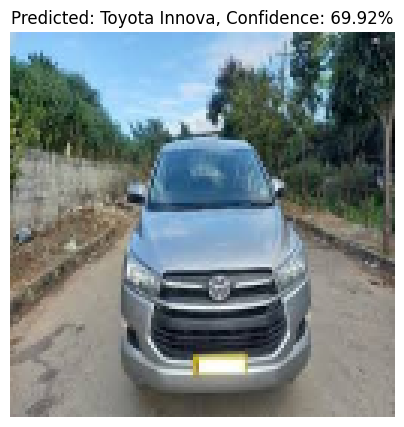

Predictions for each class:
Audi: 1.79%
Hyundai Creta: 0.65%
Mahindra Scorpio: 0.04%
Rolls Royce: 4.73%
Swift: 2.53%
Tata Safari: 20.35%
Toyota Innova: 69.92%




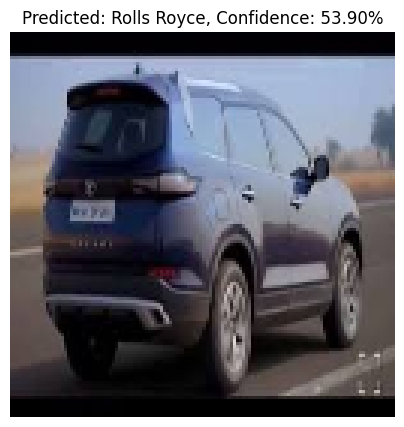

Predictions for each class:
Audi: 31.87%
Hyundai Creta: 0.10%
Mahindra Scorpio: 8.02%
Rolls Royce: 53.90%
Swift: 4.09%
Tata Safari: 1.30%
Toyota Innova: 0.72%




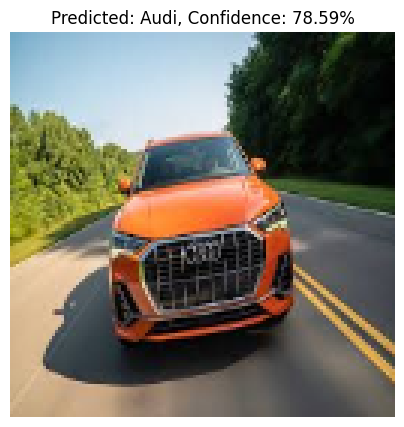

Predictions for each class:
Audi: 78.59%
Hyundai Creta: 0.10%
Mahindra Scorpio: 0.09%
Rolls Royce: 21.10%
Swift: 0.05%
Tata Safari: 0.06%
Toyota Innova: 0.01%




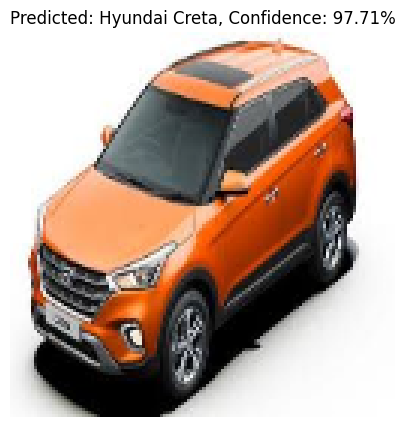

Predictions for each class:
Audi: 0.01%
Hyundai Creta: 97.71%
Mahindra Scorpio: 0.76%
Rolls Royce: 0.01%
Swift: 0.44%
Tata Safari: 0.04%
Toyota Innova: 1.01%




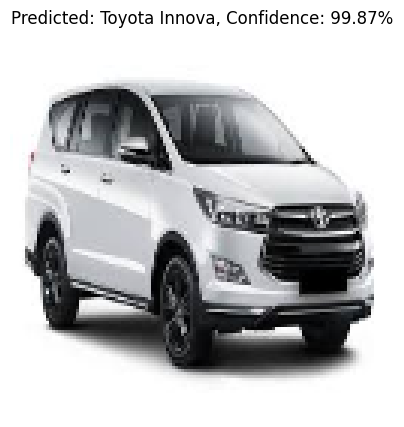

Predictions for each class:
Audi: 0.05%
Hyundai Creta: 0.07%
Mahindra Scorpio: 0.00%
Rolls Royce: 0.00%
Swift: 0.00%
Tata Safari: 0.01%
Toyota Innova: 99.87%




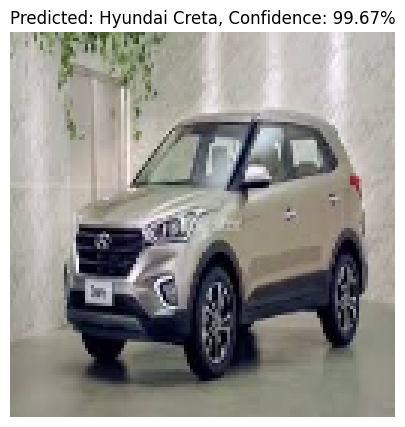

Predictions for each class:
Audi: 0.15%
Hyundai Creta: 99.67%
Mahindra Scorpio: 0.00%
Rolls Royce: 0.14%
Swift: 0.02%
Tata Safari: 0.01%
Toyota Innova: 0.01%




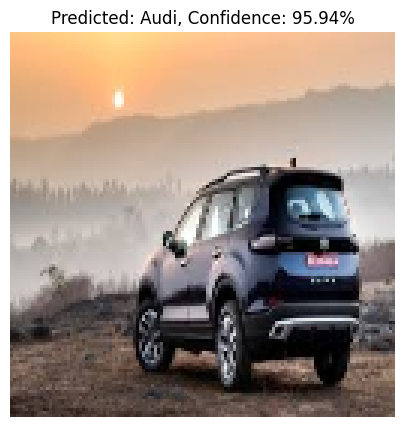

Predictions for each class:
Audi: 95.94%
Hyundai Creta: 0.00%
Mahindra Scorpio: 0.00%
Rolls Royce: 0.13%
Swift: 0.00%
Tata Safari: 3.92%
Toyota Innova: 0.01%




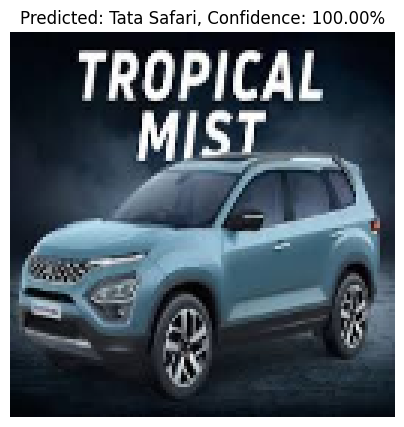

Predictions for each class:
Audi: 0.00%
Hyundai Creta: 0.00%
Mahindra Scorpio: 0.00%
Rolls Royce: 0.00%
Swift: 0.00%
Tata Safari: 100.00%
Toyota Innova: 0.00%




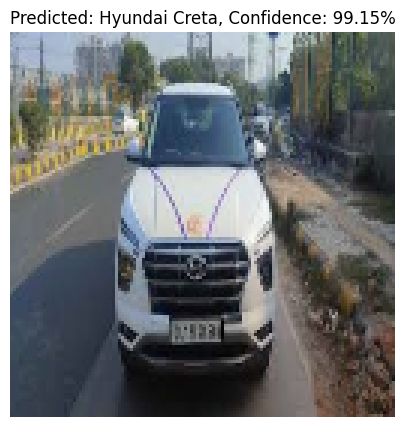

Predictions for each class:
Audi: 0.13%
Hyundai Creta: 99.15%
Mahindra Scorpio: 0.11%
Rolls Royce: 0.56%
Swift: 0.02%
Tata Safari: 0.00%
Toyota Innova: 0.02%




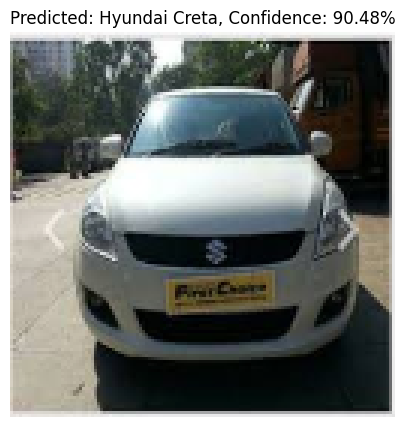

Predictions for each class:
Audi: 0.03%
Hyundai Creta: 90.48%
Mahindra Scorpio: 0.05%
Rolls Royce: 0.05%
Swift: 8.49%
Tata Safari: 0.00%
Toyota Innova: 0.90%




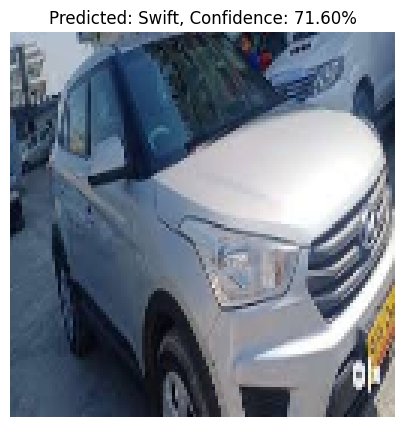

Predictions for each class:
Audi: 0.07%
Hyundai Creta: 5.68%
Mahindra Scorpio: 0.84%
Rolls Royce: 0.35%
Swift: 71.60%
Tata Safari: 0.09%
Toyota Innova: 21.37%




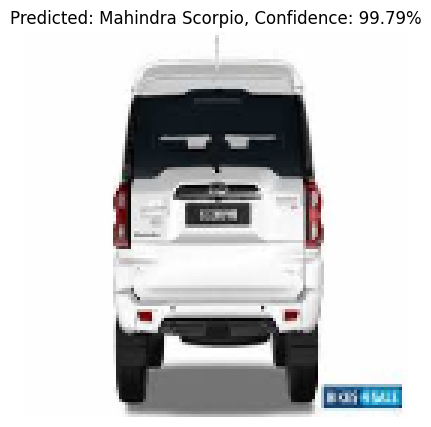

Predictions for each class:
Audi: 0.00%
Hyundai Creta: 0.21%
Mahindra Scorpio: 99.79%
Rolls Royce: 0.00%
Swift: 0.00%
Tata Safari: 0.00%
Toyota Innova: 0.00%




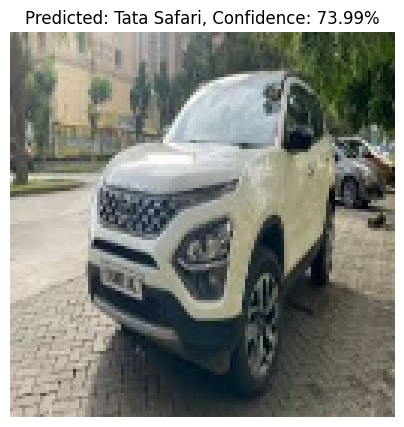

Predictions for each class:
Audi: 0.97%
Hyundai Creta: 1.95%
Mahindra Scorpio: 1.35%
Rolls Royce: 0.43%
Swift: 0.04%
Tata Safari: 73.99%
Toyota Innova: 21.27%




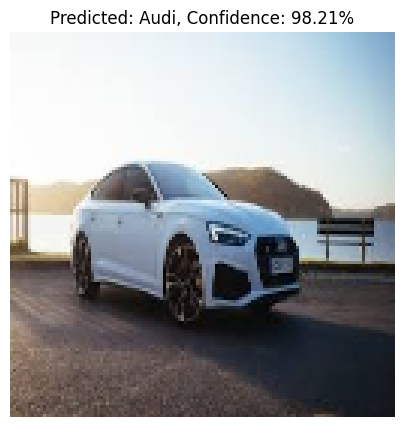

Predictions for each class:
Audi: 98.21%
Hyundai Creta: 0.00%
Mahindra Scorpio: 0.00%
Rolls Royce: 0.83%
Swift: 0.00%
Tata Safari: 0.94%
Toyota Innova: 0.01%




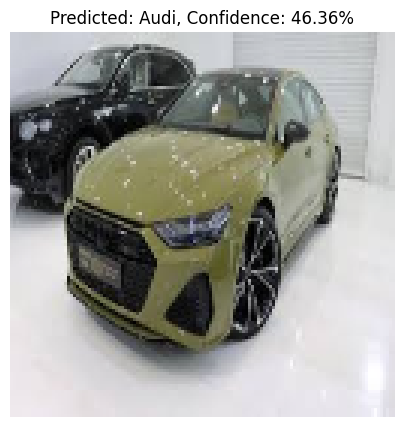

Predictions for each class:
Audi: 46.36%
Hyundai Creta: 5.78%
Mahindra Scorpio: 0.18%
Rolls Royce: 16.88%
Swift: 28.40%
Tata Safari: 0.07%
Toyota Innova: 2.32%




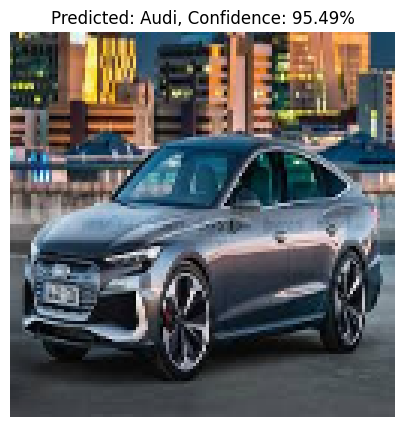

Predictions for each class:
Audi: 95.49%
Hyundai Creta: 0.04%
Mahindra Scorpio: 0.00%
Rolls Royce: 3.42%
Swift: 0.93%
Tata Safari: 0.10%
Toyota Innova: 0.00%




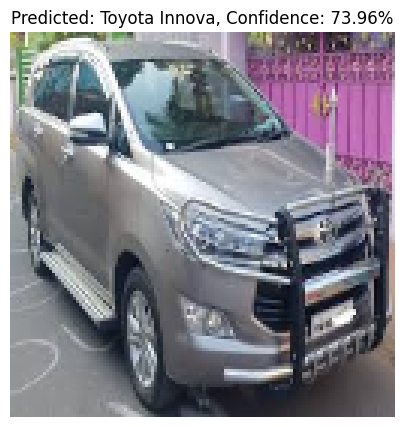

Predictions for each class:
Audi: 2.74%
Hyundai Creta: 20.39%
Mahindra Scorpio: 0.26%
Rolls Royce: 0.05%
Swift: 2.07%
Tata Safari: 0.53%
Toyota Innova: 73.96%




In [69]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_predictions(images, labels, predictions, label_encoder, num_images_to_show=30):
    num_images_to_show = min(num_images_to_show, len(images))
    
    indices = np.random.choice(len(images), num_images_to_show, replace=False)
    
    for idx in indices:
        img = images[idx].copy()
        if img.dtype != np.uint8:
            img = (img * 255).astype('uint8')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        pred_label = label_encoder.inverse_transform([labels[idx]])[0]
        confidence = np.max(predictions[idx])

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predicted: {pred_label}, Confidence: {confidence*100:.2f}%")
        plt.axis('off')
        plt.show()

        class_predictions = predictions[idx]
        print("Predictions for each class:")
        for i, conf in enumerate(class_predictions):
            class_name = label_encoder.inverse_transform([i])[0]
            print(f"{class_name}: {conf*100:.2f}%")
        print("\n")

plot_predictions(test_images, predicted_classes, predictions, label_encoder, num_images_to_show=20)
